# Nutrient analysis of global fisheries II

In [1]:
# Import python packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pymc3 as pm
import theano as T
import theano.tensor as tt
from pymc3.backends import SQLite
import seaborn as sns
import scipy as sp
import pdb

In [2]:
# Helper functions
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Helper functions
def indexall_B(L,B):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    a, b = poo.index(B), 0
    poo[b], poo[a] = poo[a], poo[b]
    
    Ix[Ix==b] = -1
    Ix[Ix==a] = 0
    Ix[Ix==-1] = a
    return poo,Ix

def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

match = lambda a, b: np.array([ b.index(x) if x in b else None for x in a ])
grep = lambda s, l: np.array([i for i in l if s in i])

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Coefficient of variation
cv =  lambda x: np.var(x) / np.mean(x)

## Import data

In [3]:
# Nutritional data
ndata = pd.read_excel('Nutrient_data.xlsx')
# Traits data
tdata = pd.read_excel('Traits_all.xlsx')

In [4]:
# Add traits information to nutritional dataframe
indx = match(ndata.Species_from_search.unique(),list(tdata.species_traits_all.values))
rindx = match(ndata.Species_from_search,list(ndata.Species_from_search.unique()))

# Traits to port over
tmp = ['Class', 'Order', 'Family','Genus_1', 'DemersPelag',
       'EnvTemp', 'DepthRangeDeep', 'trophic_level', 'Feeding_path', 'LMax',
       'BodyShapeI', 'K', 'tm']
# Port over
for trait in tmp:
    ndata[trait] = tdata[trait].values[indx][rindx]

ndata.head()

,ID_no,Species_from_search,Protein_Replicates,Protein_Value_perc,Protein_Variance,Zn_Replicates,Zn_Value,Zn_Variance,Ca_Replicates,Ca_Value,...,Genus_1,DemersPelag,EnvTemp,DepthRangeDeep,trophic_level,Feeding_path,LMax,BodyShapeI,K,tm
0,A_3,Merluccius_merluccius,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Merluccius,demersal,temperate,1075.0,4.40,pelagic,140.0,elongate,0.148,4.199469
1,A_4,Scomber_scombrus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
2,A_38,Scomber_scombrus,NaN,NaN,NaN,11,0.8090,NaN,NaN,NaN,...,Scomber,pelagic_neritic,temperate,1000.0,3.60,pelagic,60.0,fusiform,0.262,2.636997
3,A_39,Merluccius_gayi_gayi,NaN,NaN,NaN,11,0.1787,NaN,NaN,NaN,...,Merluccius,pelagic_oceanic,polar_deep,500.0,4.26,pelagic,87.0,fusiform,0.120,5.100000
4,A_40,Engraulis_encrasicolus,NaN,NaN,NaN,11,0.7041,NaN,NaN,NaN,...,Engraulis,pelagic_neritic,subtropical,400.0,3.12,pelagic,20.0,elongate,1.000,1.000000


In [5]:
ndata.columns.values

array(['ID_no', 'Species_from_search', 'Protein_Replicates',
       'Protein_Value_perc', 'Protein_Variance', 'Zn_Replicates',
       'Zn_Value', 'Zn_Variance', 'Ca_Replicates', 'Ca_Value',
       'Ca_Variance', 'Fe_Replicates', 'Fe_Value', 'Fe_Variance',
       'Se_Replicates', 'Se_Value', 'Se_Variance', 'P_Replicates',
       'P_Value', 'P_Variance', 'Mg_Replicates', 'Mg_Value',
       'Mg_Variance', 'VitA_Replicates', 'VitA_Value', 'VitA_Variance',
       'VitB12_Replicates', 'VitB12_Value', 'VitB12_Variance',
       'O3_Replicates', 'O3_Value', 'O3_Variance', 'Unnamed: 32',
       'Form_Clean', 'Search', 'Year', 'GeographicLocation_Cleaned',
       'Family', 'Prep', 'Protein_prep', 'Minerals_prep', 'Vitamin_prep',
       'FA_prep', 'Protein_Sample_Weight', 'Zn_Sample_Weight',
       'Ca_Sample_Weight', 'Fe_Sample_Weight', 'Se_Sample_Weight',
       'P_Sample_Weight', 'Mg_Sample_Weight', 'VitA_Sample_Weight',
       'VitB12_Sample_Weight', 'O3_Sample_Weight', 'Class', 'Order',
     

### Datasets

In [6]:
Nutrients = ['Protein', 'Zinc', 'Iron', 'Calcium', 'Omega-3', 'Vitamin_A', 'Selenium']
Nkeys = ['Protein_Value_perc', 'Zn_Value', 'Fe_Value', 'Ca_Value', 'O3_Value', 'VitA_Value', 'Se_Value']
nnutrients = len(Nutrients)

In [7]:
# Sample sizes for each nutrient
[sum(np.isnan(ndata[n].values)==False) for n in Nkeys]

[627, 196, 173, 170, 176, 69, 134]

## ======= Change nutrient here & likelihood in the model ========= #

In [8]:
i = 3
nut = Nutrients[i]
nut

'Calcium'

In [9]:

# Response
var = Nkeys[i]
Y_ = ndata[var].values


In [10]:
len(Y_)

932

In [11]:
# Units
#'Protein' - g/100g OK
#'Zinc' - mg/100g ---> multiply by 10
#'Iron' - mg/100g ---> multiply by 10
#'Calcium' - mg/100g OK
#'Omega-3': - g/100g ----> multiply by 10
#'Vitamin_A' - μg/100g OK
#'Selenium' - μg/100g OK


# Response
var = Nkeys[i]
Y_ = ndata[var].values

# NA Filter
indx = np.isfinite(Y_)
### ZEROS Filter
if nut in ['Selenium', 'Calcium']:
    indx = indx*(Y_>0)
    
### Protein beyond 60% Filter
if nut in ['Protein']:
    indx = indx*(Y_<60)
    
### Zinc beyond 11 Filter
if nut in ['Zinc']:
    indx = indx*(Y_<10)

# Remove non-useful data
Y_ = Y_[indx]

# Unit conversions for better models
#if nut in ['Zinc','Iron','Omega-3']:
#    Y_ = Y_*10

    
# Log-scale
Ylog = np.log(Y_+1)

# Observation scale
Y = Y_
# Filter dataframe
tmpdata = ndata[indx]

# Index for orders
Order,Io = indexall(tmpdata.Order.values)
nord = len(Order)

# Covariates
Habitat,Ih = indexall_B(tmpdata['DemersPelag'].values, 'demersal')
nhabs = len(Habitat)
Climate,Ic = indexall_B(tmpdata['EnvTemp'].values, 'temperate')
nclim = len(Climate)
MaxDepth = np.log(tmpdata['DepthRangeDeep'].values)
TL = tmpdata['trophic_level'].values
Pelagic = tmpdata['Feeding_path'].values=="pelagic"
LMax = np.log(tmpdata['LMax'].values)
Body,Ib = indexall_B(tmpdata['BodyShapeI'].values, 'fusiform')
nbod = len(Body)
K = tmpdata['K'].values
tm = np.log(tmpdata['tm'].values)

# Nussiance parameters
Form,If = indexall_B(tmpdata['Form_Clean'].values, 'muscle')
nform = len(Form)
Prep,Ip = indexall_B(tmpdata['Prep'].values, 'wet')
nprep = len(Prep)
Search,Is = indexall_B(tmpdata['Search'].values, 'WOS')
nsearch = len(Search)
Geog,Ig = indexall(tmpdata['GeographicLocation_Cleaned'].values)
ngeo = len(Geog)

In [12]:
Body

['fusiform', 'short_deep', 'elongate', 'flat']

In [13]:
Habitat

['demersal',
 'benthopelagic',
 'pelagic_neritic',
 'pelagic_oceanic',
 'reef_associated']

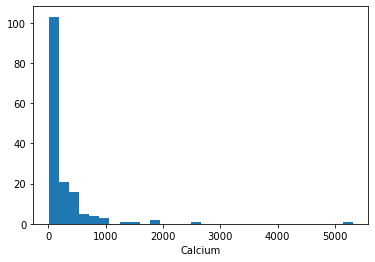

In [14]:
plt.hist(Y,bins=30)
plt.xlabel(nut);

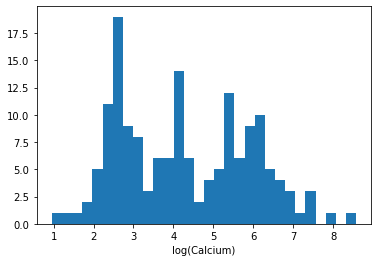

In [15]:
plt.hist(Ylog,bins=30)
plt.xlabel('log('+nut+')');

## Specify Bayesian model

In [16]:
Model_1 = pm.Model()

with Model_1:
    # Intercept
    γ0 = pm.Normal('Intercept', mu=0, tau=0.0001)
    # Observation model
    #σγ = pm.Uniform('Sigma_γ', 0, 100)
    #β0 = pm.Normal('Order', mu=γ0, sd=σγ, shape=nord)
    #pi_tilde = pm.Normal('pi_t', 0, 1, shape=nord)
    #β0 = pm.Deterministic('Order', γ0 + σγ*pi_tilde)
    # Random effect of data-source
    #β01 = pm.Normal('Geography', 0, 1, shape=ngeo)
    
    #"""
    # Habitat type
    β1_ = pm.Normal('Habitat', 0, tau=0.01, shape=nhabs-1)
    β1 = tt.set_subtensor(tt.zeros(shape=nhabs)[1:], β1_)
    # Climate
    β2_ = pm.Normal('Climate', 0, tau=0.01, shape=nclim-1)
    β2 = tt.set_subtensor(tt.zeros(shape=nclim)[1:], β2_)
    # Maximum Depth
    β3 = pm.Normal('MaxDepth', 0, tau=0.01)
    # Total Length
    β4 = pm.Normal('TL', 0, tau=0.01)
    # Pelagic/demersal
    β5 = pm.Normal('pelagic', 0, tau=0.01)
    # Maximum length
    β6 = pm.Normal('LMax', 0, tau=0.01)
    # Body form
    β7_ = pm.Normal('Body', 0, tau=0.01, shape=nbod-1)
    β7 = tt.set_subtensor(tt.zeros(shape=nbod)[1:], β7_)
    # Growth parameter
    β8 = pm.Normal('K', 0, tau=0.01)
    # Age at maturity
    β9 = pm.Normal('tm', 0, tau=0.01)
    
    # Form of sample
    β10_ = pm.Normal('Form', 0, tau=0.01, shape=nform-1)
    β10 = tt.set_subtensor(tt.zeros(shape=nform)[1:], β10_)
    # Form of prepartion
    β11_ = pm.Normal('Prep', 0, tau=0.01, shape=nprep-1)
    β11 = tt.set_subtensor(tt.zeros(shape=nprep)[1:], β11_)
    # Database used
    β12_ = pm.Normal('Search', 0, tau=0.01, shape=nsearch-1)
    β12 = tt.set_subtensor(tt.zeros(shape=nsearch)[1:], β12_)
    
    #"""
    
    # Mean model
    μ_ = γ0+β1[Ih]+β2[Ic]+β3*MaxDepth+β4*TL+β5*Pelagic+β6*LMax+β7[Ib]+β8*K+β9*tm+β10[If]+β11[Ip]+β12[Is]
    #μ_ = β0[Io]
    
    # Normal - log-Calcium (3)
    #μ = μ_
    #σ = pm.Uniform('Sigma', lower=0, upper=10)
    #Yi = pm.Normal('Yi', mu=μ, sd=σ, observed=Ylog)
    
    # ST -
    μ = μ_
    ν = pm.Uniform('nu', lower=0, upper=10)
    σ = pm.Uniform('Sigma', lower=0, upper=10)
    Yi = pm.StudentT('Yi', nu=ν, mu=μ, sd=σ, observed=Ylog)
    
    # Gamma model -
    #μ = tt.exp(μ_)
    #α = pm.Uniform('α', lower=0., upper=100.)
    #Yi = pm.Gamma('Yi', alpha=α, beta=α/μ, observed=Ylog)
    
    # Pareto model - 
    #μ = tt.exp(μ_)
    #Yi = pm.Pareto('Yi', μ, m=min(Y), observed=Y)
    

In [17]:
# Sampling
with Model_1:
    # Draw samples
    trace = pm.sample(5000, progressbar=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [Sigma, nu, Search, Prep, Form, tm, K, Body, LMax, pelagic, TL, MaxDepth, Climate, Habitat, Intercept]


Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 126 seconds.


## Divergence analysis

In [18]:
def pairplot_divergence(trace, basevar, targetvar, ax=None, divergence=True, color='C3', divergence_color='C2'):
    #theta = trace.get_values(varname=basevar, combine=True)[:, 0]
    theta = trace.get_values(varname=basevar, combine=True)
    logtau = trace.get_values(varname=targetvar, combine=True)
    if not ax:
        _, ax = plt.subplots(1, 1, figsize=(10, 5))
    ax.plot(theta, logtau, 'o', color=color, alpha=.5)
    if divergence:
        divergent = trace['diverging']
        ax.plot(theta[divergent], logtau[divergent], 'o', color=divergence_color)
    ax.set_xlabel(basevar)
    ax.set_ylabel(targetvar)
    ax.set_title('scatter plot between log('+targetvar+') and '+basevar);
    return ax

In [19]:
# A small wrapper function for displaying the MCMC sampler diagnostics as above
def report_trace(trace,basevar,targetvar,logscale=False):
    # plot the trace of log(tau)
    pm.traceplot({targetvar: trace.get_values(varname=targetvar, combine=False)});

    # plot the estimate for the mean of log(τ) cumulating mean
    if logscale:
        logtau = np.log(trace[targetvar])
    else:
        logtau = trace[targetvar]
    mlogtau = [np.mean(logtau[:i]) for i in np.arange(1, len(logtau))]
    plt.figure(figsize=(15, 4))
    #plt.axhline(0.7657852, lw=2.5, color='gray')
    plt.plot(mlogtau, lw=2.5)
    plt.ylim(0, 2)
    plt.xlabel('Iteration')
    plt.ylabel('MCMC mean of log('+targetvar+')')
    plt.title('MCMC estimation of log('+targetvar+')')
    plt.show()

    # display the total number and percentage of divergent
    divergent = trace['diverging']
    print('Number of Divergent %d' % divergent.nonzero()[0].size)
    divperc = divergent.nonzero()[0].size / len(trace) * 100
    print('Percentage of Divergent %.1f' % divperc)

    # scatter plot between log(tau) and theta[0]
    # for the identifcation of the problematic neighborhoods in parameter space
    pairplot_divergence(trace,basevar,targetvar);

In [20]:
#report_trace(trace,'Intercept','Sigma_γ')

## Summary plots

In [21]:
pm.summary(trace)

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
Intercept,8.007,1.087,5.878,9.984,0.011,0.008,10317.0,10269.0,10330.0,12457.0,1.0
Habitat[0],0.560,0.270,0.060,1.063,0.002,0.002,14069.0,14068.0,14105.0,15619.0,1.0
Habitat[1],0.069,0.333,-0.551,0.696,0.003,0.002,9594.0,9594.0,9604.0,13280.0,1.0
Habitat[2],-0.033,0.405,-0.785,0.736,0.003,0.003,13821.0,12443.0,13807.0,14550.0,1.0
Habitat[3],0.065,0.556,-0.973,1.119,0.004,0.004,19643.0,9189.0,19624.0,13913.0,1.0
Climate[0],1.820,0.289,1.270,2.353,0.003,0.002,12148.0,11923.0,12145.0,12310.0,1.0
Climate[1],1.790,0.321,1.179,2.381,0.003,0.002,12074.0,12074.0,12073.0,14430.0,1.0
Climate[2],-0.629,0.300,-1.188,-0.063,0.002,0.002,20100.0,18035.0,20124.0,15116.0,1.0
MaxDepth,0.098,0.086,-0.067,0.255,0.001,0.001,16772.0,14615.0,16768.0,15015.0,1.0
TL,0.028,0.197,-0.360,0.384,0.002,0.001,15163.0,11636.0,15170.0,13908.0,1.0


/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


<Figure size 1224x792 with 0 Axes>

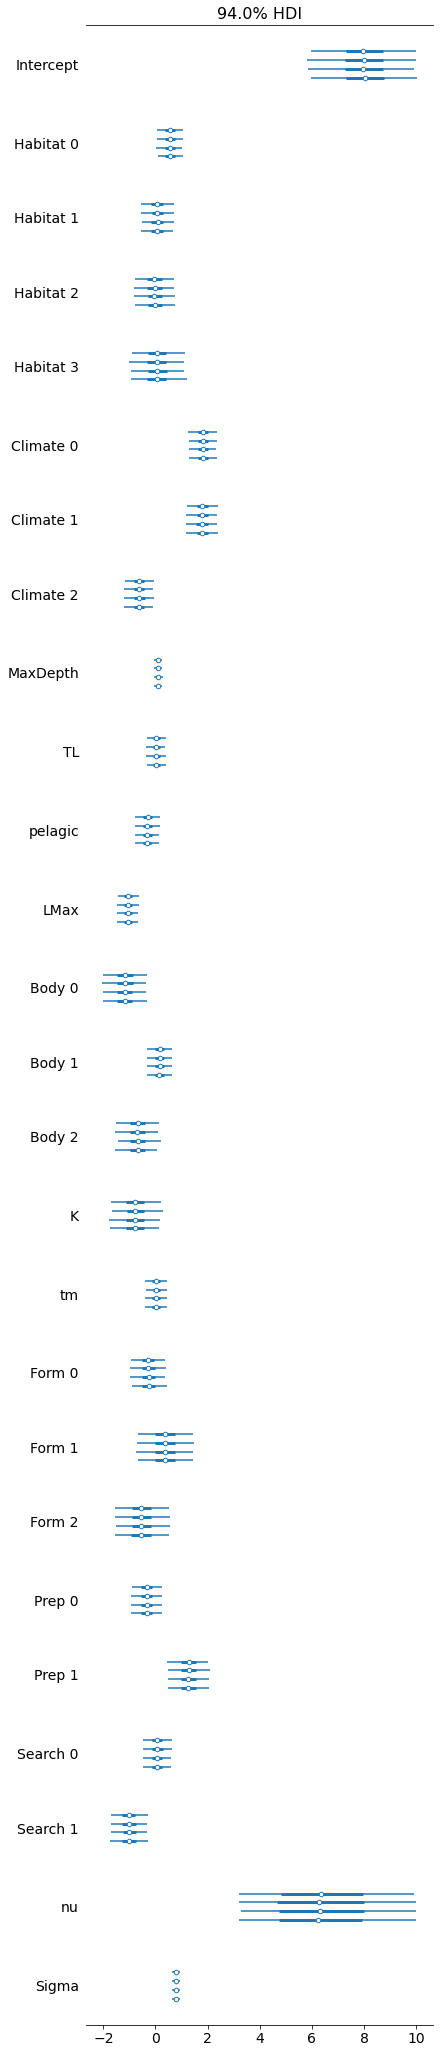

In [22]:
plt.figure(figsize=(17, 11))
pm.forestplot(trace)
plt.savefig('Figure_S3_'+nut+'.jpg',dpi=300);

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


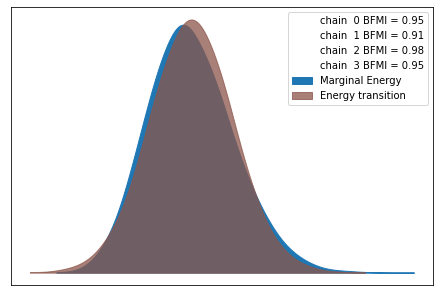

In [23]:
pm.plots.energyplot(trace);

In [24]:
pm.stats.waic(trace, Model_1)

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/stats/stats.py:1413: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 20000 by 158 log-likelihood matrix

          Estimate       SE
elpd_waic  -233.71    11.15
p_waic       32.42        -

There has been a warning during the calculation. Please check the results.

The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if
you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive
accuracy.

In [25]:
# Export results 
out = pm.backends.tracetab.trace_to_dataframe(trace)
colnames = np.array(list(out.columns), dtype=object)
# Rename columns
colnames[match(grep('Habitat',list(colnames)),list(colnames))] = Habitat[1:]
colnames[match(grep('Climate',list(colnames)),list(colnames))] = Climate[1:]
colnames[match(grep('Body',list(colnames)),list(colnames))] = Body[1:]
colnames[match(grep('Form',list(colnames)),list(colnames))] = Form[1:]
colnames[match(grep('Prep',list(colnames)),list(colnames))] = Prep[1:]
colnames[match(grep('Search',list(colnames)),list(colnames))] = Search[1:]
# Rename
out.columns = list(colnames)

In [26]:
# Add baseline columns to dataframe
out['demersal'] = 0
out['temperate'] = 0
out['fusiform'] = 0
out['muscle'] = 0
out['wet'] = 0
out['WOS'] = 0

In [27]:
out.to_csv(nut+'_results.csv')

In [28]:
out.head()

,Intercept,benthopelagic,pelagic_neritic,pelagic_oceanic,reef_associated,subtropical,tropical,polar_deep,MaxDepth,TL,...,Expert,FAO,nu,Sigma,demersal,temperate,fusiform,muscle,wet,WOS
0,7.595641,0.839107,0.354497,0.617382,0.939724,1.814311,1.650410,-0.557877,0.161402,-0.177586,...,0.142590,-1.121068,5.008848,0.835201,0,0,0,0,0,0
1,6.970448,0.909062,0.508497,0.454747,0.672826,1.686345,1.380309,-0.572164,0.202392,-0.225586,...,-0.054506,-1.496643,5.096681,0.783014,0,0,0,0,0,0
2,6.929033,0.409309,0.131347,-0.390606,1.542721,1.810375,1.573384,-0.273048,0.090877,0.335519,...,0.160727,-0.830381,5.521439,0.785452,0,0,0,0,0,0
3,8.347134,0.663517,-0.261253,-0.026720,-0.791365,1.891377,1.690023,-0.950096,0.046429,0.062198,...,0.230190,-0.973831,5.726655,0.751135,0,0,0,0,0,0
4,8.445899,0.702459,-0.342742,-0.107545,-0.497940,1.687956,1.407393,-0.707525,0.007005,-0.020840,...,0.608065,-0.689189,6.648023,0.860755,0,0,0,0,0,0


### Model-checking

In [29]:
ppc = pm.sample_posterior_predictive(trace, model=Model_1)

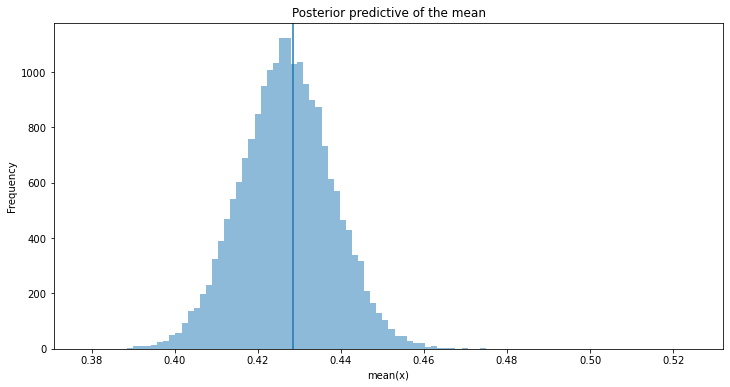

In [30]:
_, ax = plt.subplots(figsize=(12, 6))
ax.hist([n.mean()/10 for n in ppc['Yi']], bins=100, alpha=0.5)
ax.axvline(Ylog.mean()/10)
ax.set(title='Posterior predictive of the mean', xlabel='mean(x)', ylabel='Frequency')
plt.savefig('Figure_S4_'+nut+'.jpg',dpi=300);

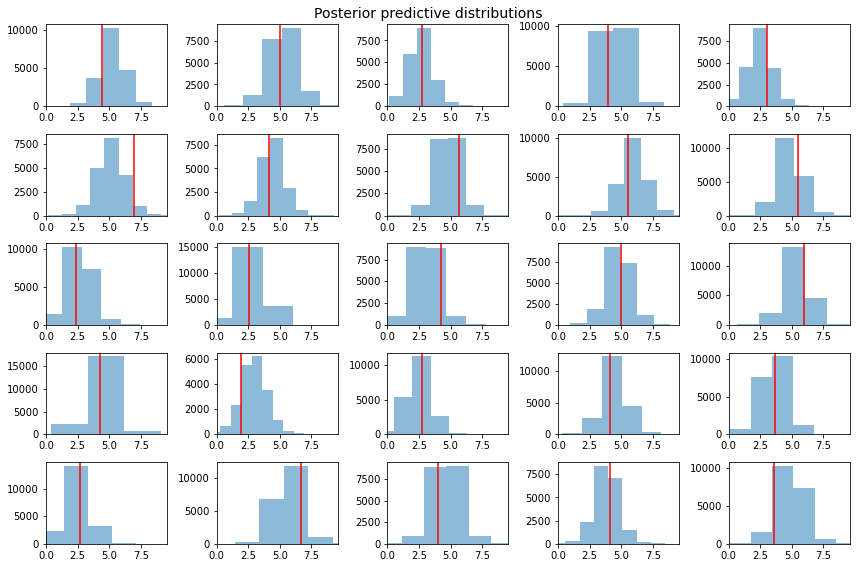

In [31]:
# Setup multipanel figure
nrows, ncols = 5, 5
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12,8))
ax_ = axes.flatten()

# Transform ppc
PPC = ppc['Yi'].T
# Index random observations
indx = np.random.randint(0,len(PPC),size=nrows*ncols)

# Iterate over random samples from ppc
for i in range(nrows*ncols):
    ax1 = ax_[i]
    ax1.hist(PPC[indx[i]], bins=19, alpha=0.5)
    ax1.axvline(Ylog[indx[i]],c='red')
    ax1.set_xlim(0,max(Ylog)+1)

fig.tight_layout()
fig.suptitle('Posterior predictive distributions', fontsize=14)
fig.subplots_adjust(top=0.95)
plt.savefig('Figure_S5_'+nut+'.jpg',dpi=300);

In [32]:
def abline(intercept, slope):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--',c='grey')

In [33]:
Io

array([ 0,  0,  1,  0,  0,  2,  3,  0,  0,  0,  4,  1,  4,  0,  1,  1,  1,
        1,  0,  1,  0,  0,  1,  0,  0,  0,  3,  0,  0,  0,  4,  0,  3,  1,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  5,  5,  5,  6,  6,  6,  5,
        5,  5,  5,  5,  0,  2,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,  1,
        1,  1,  5,  6,  6,  5,  2,  5,  2,  2,  0,  1,  7,  7,  7,  7,  0,
        6,  6,  7,  7,  7,  2,  7,  7,  0,  0,  0,  0,  1,  0,  0,  3,  7,
        8,  0,  0,  0,  3,  7,  1,  0,  0,  1,  4,  0,  0,  0,  0,  5,  5,
        5,  3,  1,  0,  0,  1,  9,  5,  1,  7,  5,  6,  0,  0,  0,  0,  0,
        3,  0, 10,  1,  1])

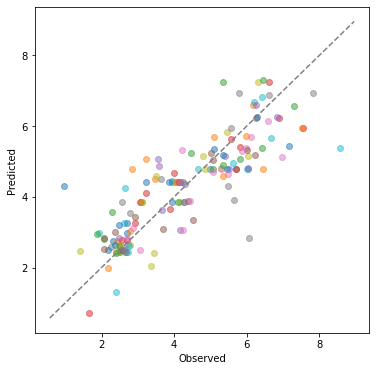

In [34]:
plt.subplots(figsize=(6, 6))
nobs = len(Ylog)
#ocol = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6','#6a3d9a','#ffff99','#b15928']

# Iterate over random samples from ppc
for i in range(nobs):
    plt.scatter(Ylog[i], np.median(PPC[i]), alpha=0.5)

plt.xlabel('Observed')
plt.ylabel('Predicted')

abline(0,1)
    
fig.tight_layout()
plt.savefig('Figure_S6_'+nut+'.jpg',dpi=300);

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


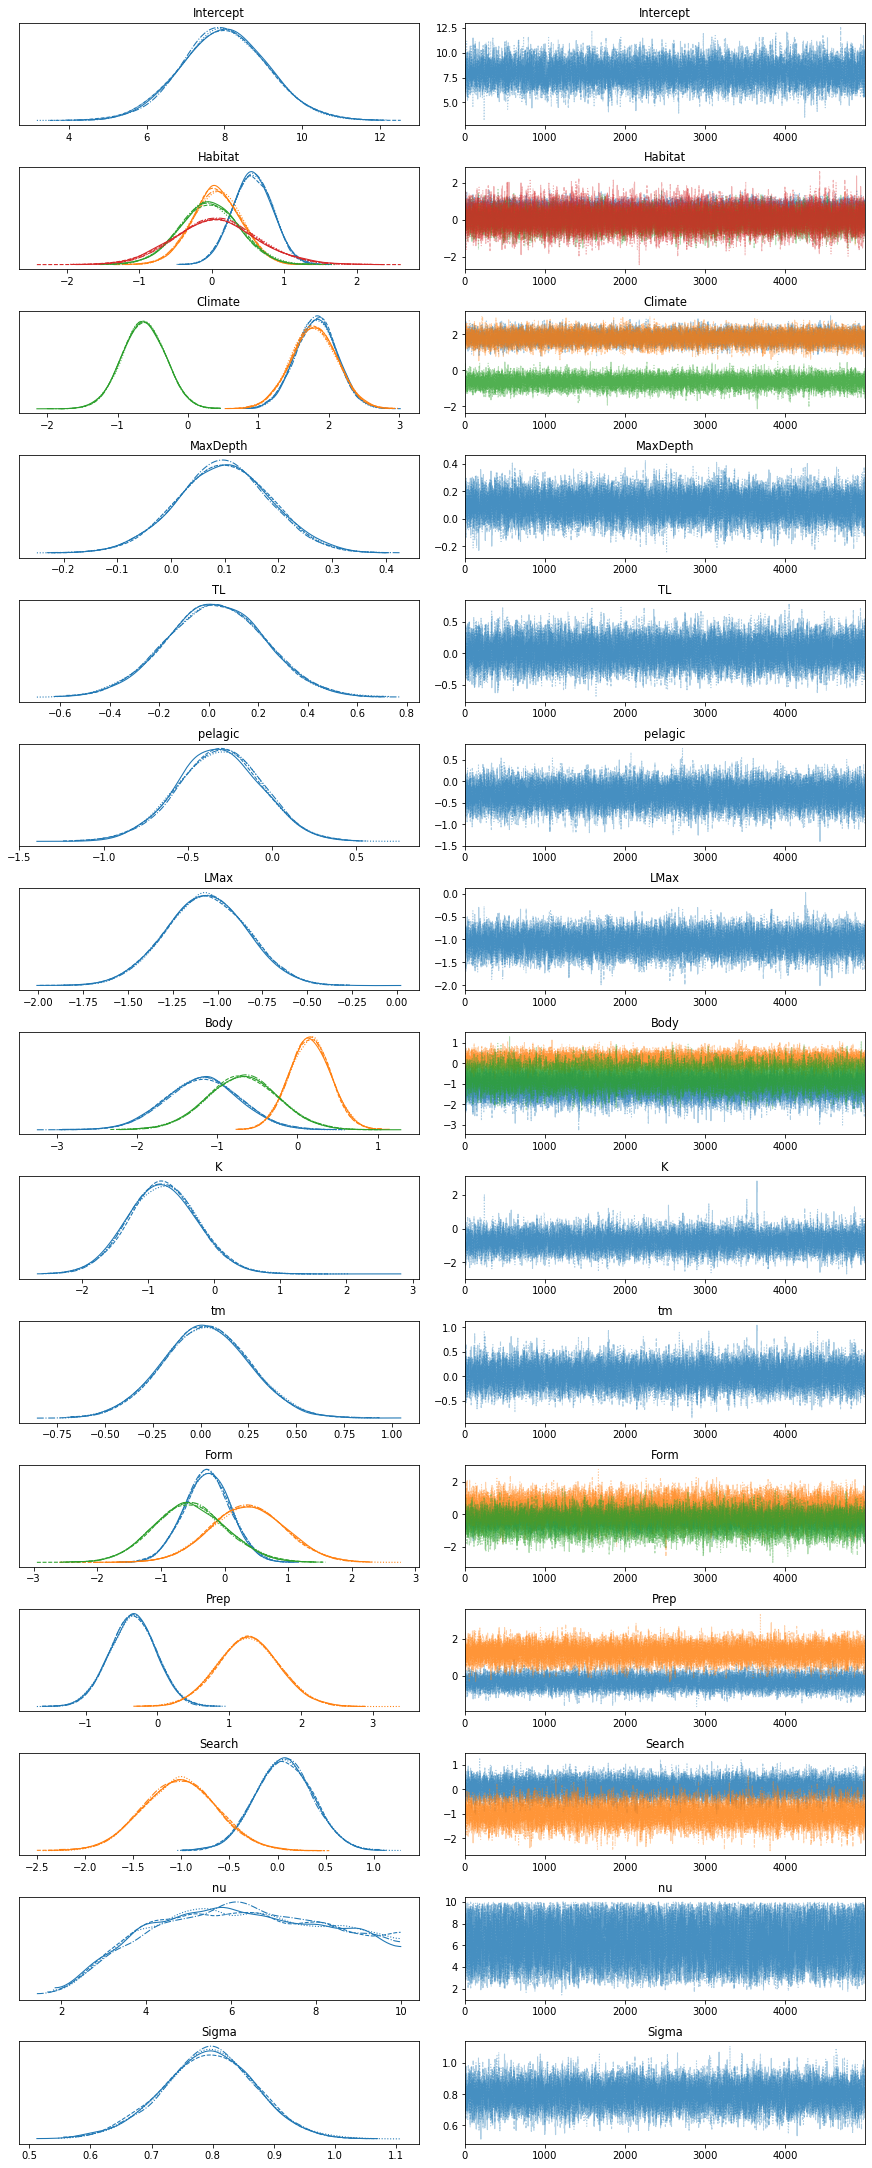

In [35]:
pm.traceplot(trace)
plt.savefig('Figure_S2_'+nut+'.jpg',dpi=300);

In [36]:
min([np.median(p) for p in PPC])

0.7197814390843189

In [37]:
max([np.median(p) for p in PPC])

7.293050252186108

In [38]:
min(Ylog)

0.9555114450274363

In [39]:
max(Ylog)

8.577535420422398

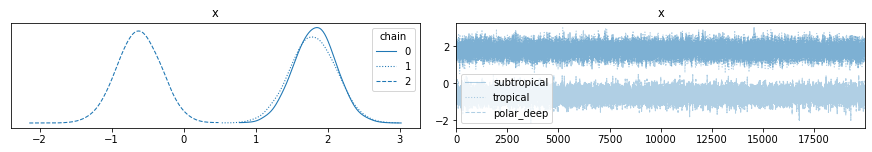

In [40]:
pm.traceplot(trace['Climate'].T, legend=True)
plt.legend(Climate[1:]);
#plt.savefig('Figure_S2_'+nut+'.jpg',dpi=300);

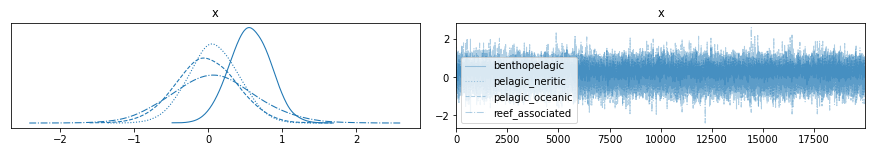

In [41]:
pm.traceplot(trace['Habitat'].T)
plt.legend(Habitat[1:]);
#plt.savefig('Figure_S2_'+nut+'.jpg',dpi=300);

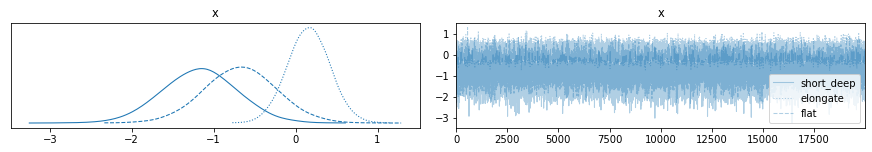

In [42]:
pm.traceplot(trace['Body'].T)
plt.legend(Body[1:]);

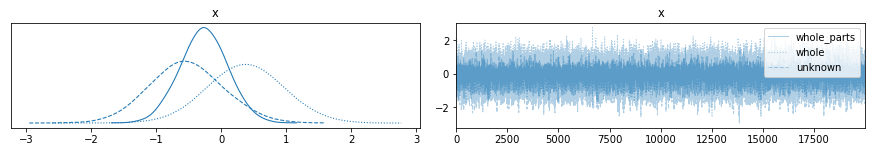

In [43]:
pm.traceplot(trace['Form'].T)
plt.legend(Form[1:]);

/Users/aaronmacneil/opt/anaconda3/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


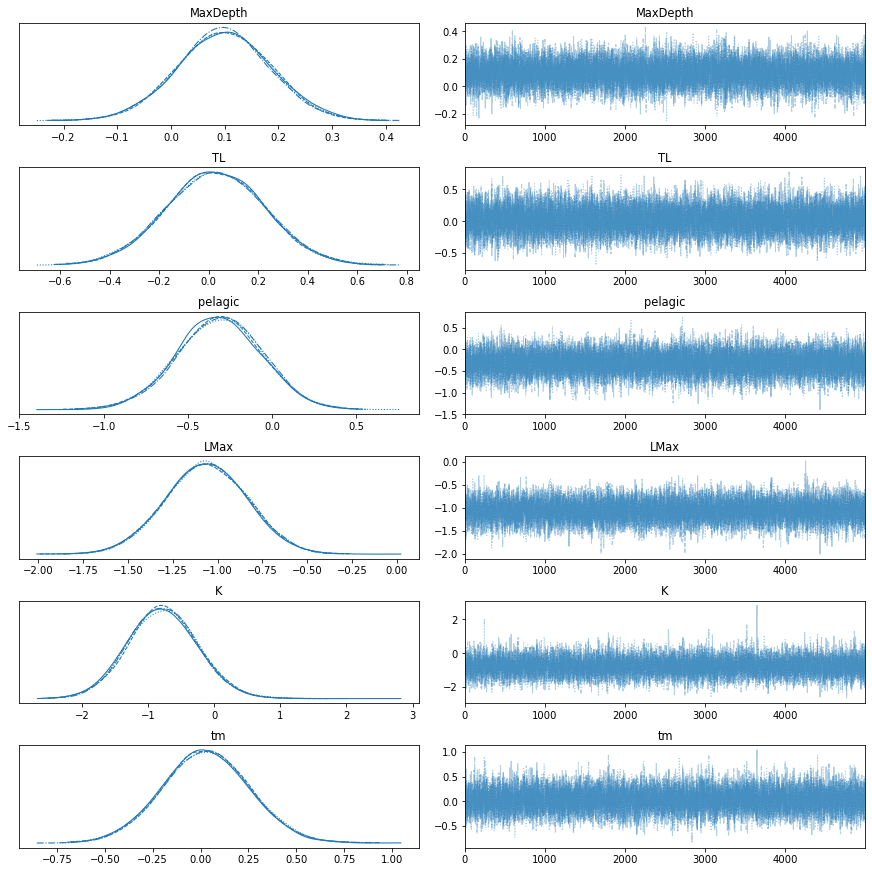

In [44]:
pm.traceplot(trace, var_names=['MaxDepth','TL','pelagic','LMax','K','tm']);